In [8]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT, FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart, plot_forecasting_eval, plot_forecasting_series
from matplotlib.pyplot import figure, savefig, subplots

In [9]:
filename: str = "datasets/forecasting_covid_transformed.csv"
file_tag: str = "forecasting_covid_evaluation"
target: str = "deaths"
timecol: str = "date"
measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.90)

predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 deaths   No. Observations:                  133
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5106.755
Date:                Sat, 23 Dec 2023   AIC                          10225.511
Time:                        23:52:46   BIC                          10242.808
Sample:                    12-28-2020   HQIC                         10232.540
                         - 07-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7802      0.009     86.116      0.000       0.762       0.798
ar.L2          0.9999      0.016     62.532      0.000       0.969       1.031
ar.L3         -0.7802      0.007   -110.933      0.0

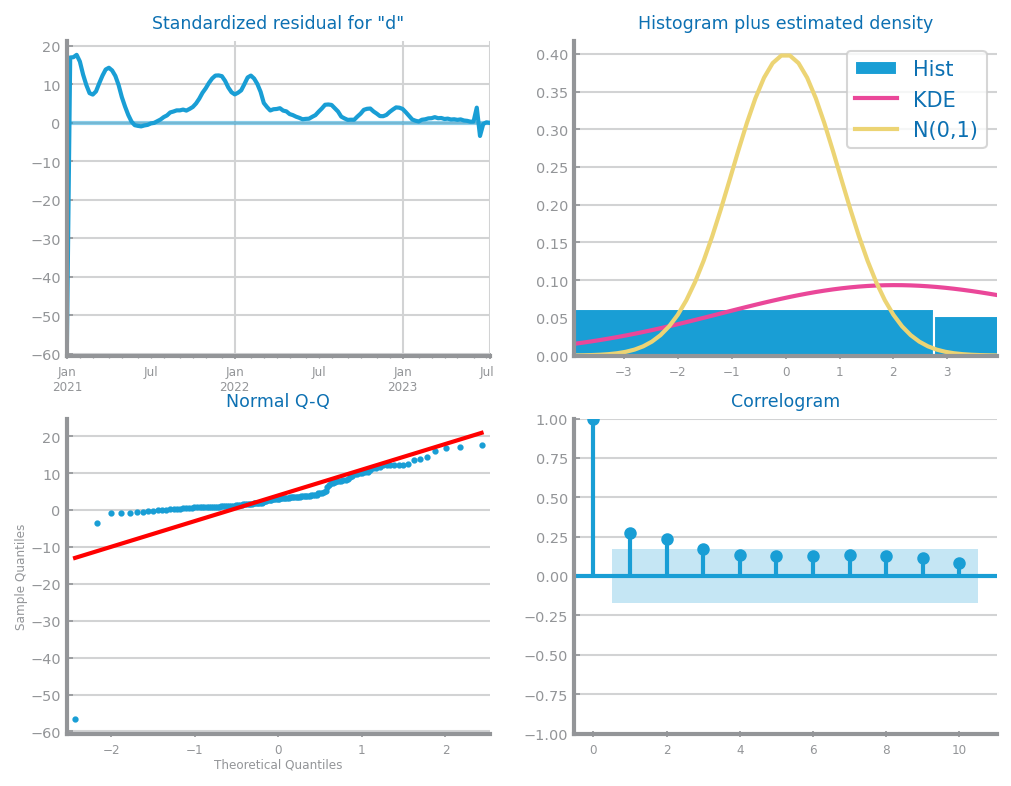

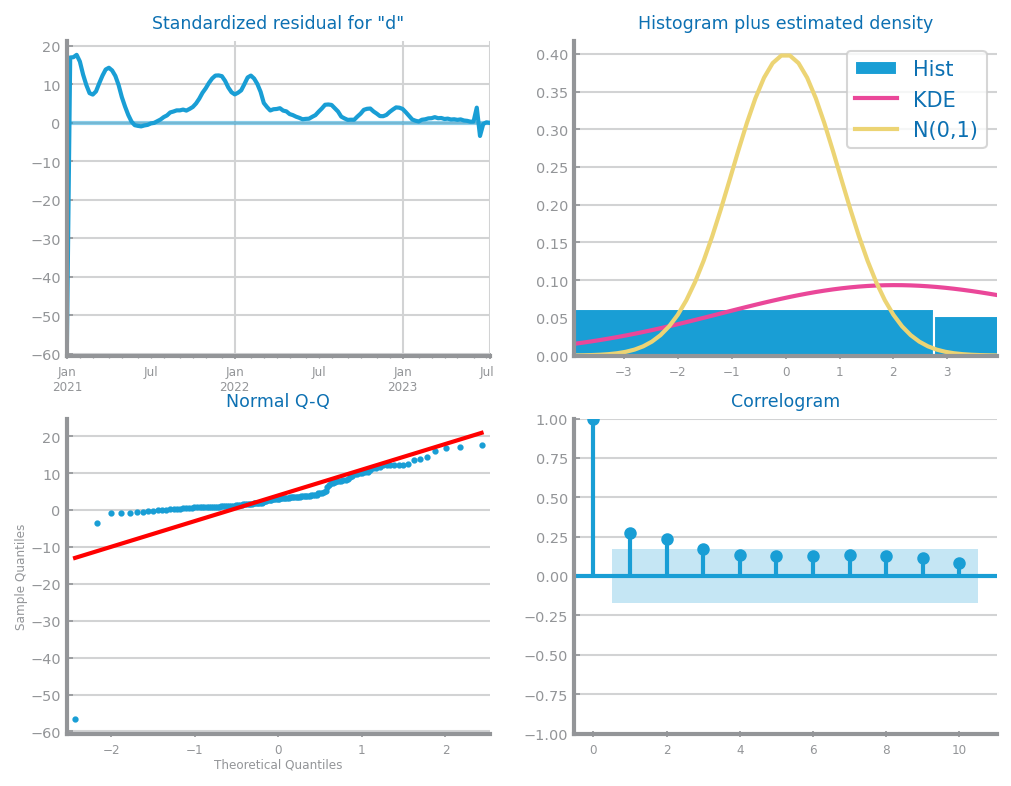

In [10]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

In [11]:
def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

ARIMA best results achieved with (p,d,q)=(10, 2, 3) ==> measure=0.96


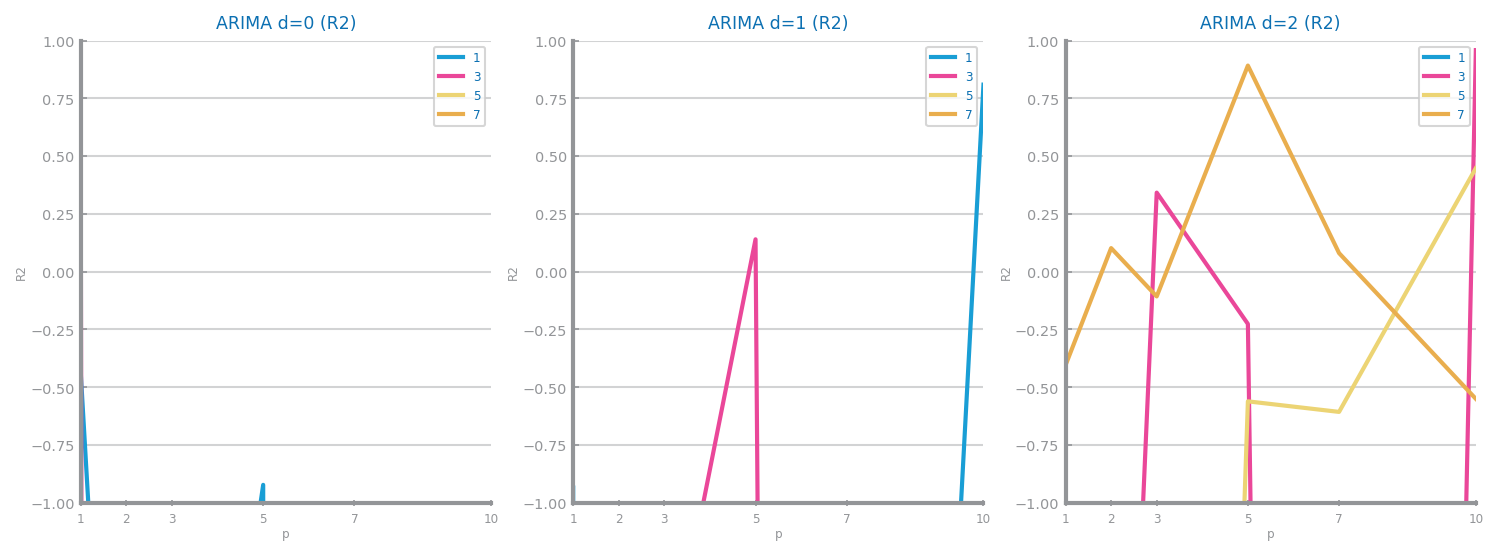

In [13]:
best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"images/forecast/modeling/{file_tag}_arima_{measure}_study.png")

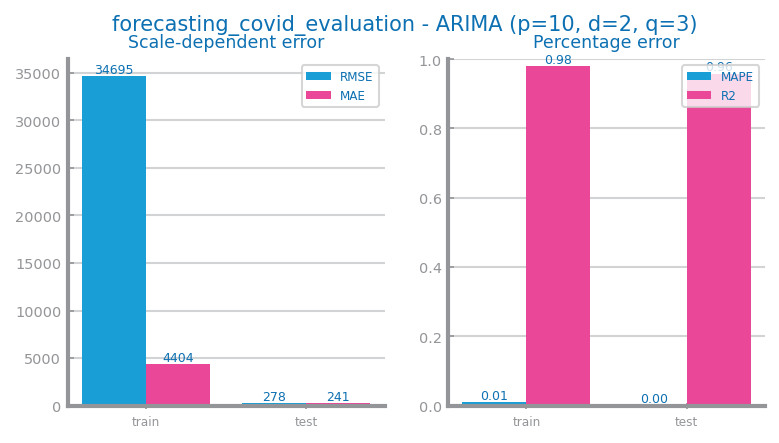

In [14]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/forecast/modeling/{file_tag}_arima_{measure}_eval.png")

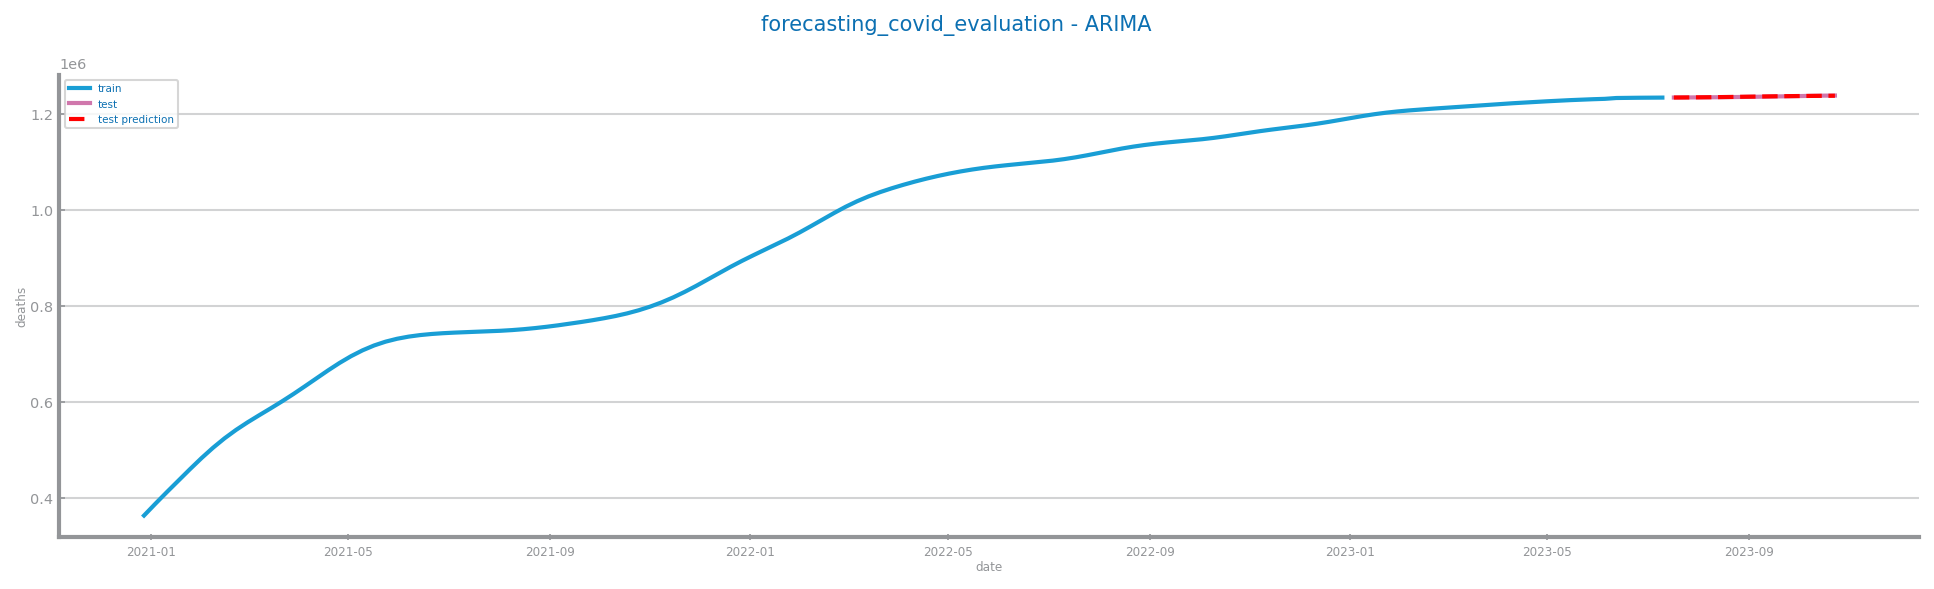

In [15]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/forecast/modeling/{file_tag}_arima_{measure}_forecast.png")